<a href="https://colab.research.google.com/github/amyth18/CS598-Deep-Learning-Final-Project/blob/main/Additional_Expertiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install datasets
! pip install transformers

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PROJECT_PATH = "/content/drive/My Drive/DLH Final Project"
W2V_MODEL_PATH = f"{PROJECT_PATH}/models/word2vec.model"

W2V_EMB_SIZE = 128
LSTM_HIDDEN_VEC_SIZE = 100
TRAINING_BATCH_SIZE = 400

In [ ]:
import pandas as pd

In [ ]:
df_dataset = pd.read_csv(f"{PROJECT_PATH}/mimic3/df_dataset_bert_kbr.csv",
                         converters={'SYMPTOMS': eval, 'ICD9_CODE': eval})

In [ ]:
df_icd_codes = pd.read_csv(f"{PROJECT_PATH}/mimic3/DIAGNOSES_ICD.csv")
df_icd_codes.dropna()
df_icd_codes['ICD9_CODE'] = df_icd_codes['ICD9_CODE'].astype("string")
counts = df_icd_codes["ICD9_CODE"].value_counts().head(50)
top_icd_codes = counts.index.to_list()

sorted_top_icd_codes = sorted(top_icd_codes)
icd_code_to_idx = dict((k, v) for v, k in enumerate(sorted_top_icd_codes))

In [ ]:
# new col to be added to dataframe
multi_hot_ecoding_col = list()
for idx in range(len(df_dataset)):
  icd_codes = df_dataset.iloc[idx]['ICD9_CODE']
  encoding = [0] * 50
  for code in icd_codes:
    encoding[icd_code_to_idx[code]] = 1    
  multi_hot_ecoding_col.append(encoding)

# new add a new column with multi-hot encoding.
df_dataset['ICD9_CODE_ENCODED'] = multi_hot_ecoding_col

# multi-hot encoding for ICD codes diagnosed.
y = df_dataset['ICD9_CODE_ENCODED'].to_list()

In [ ]:
len(y), len(df_dataset)

(54946, 54946)

In [ ]:
df_dataset = df_dataset.rename(columns=dict(ICD9_CODE_ENCODED="labels"))

In [ ]:
df_dataset.head()

,Unnamed: 0,SUBJECT_ID,HADM_ID,ICD9_CODE,SYMPTOMS,labels
0,0,22532,167853.0,"[42731, 2762, 5070, 5119]","[cavitary lesions in the left lung apex, infec...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,22532,167853.0,"[42731, 2762, 5070, 5119]","[a productive cough, 30 lb weight loss, shortn...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,13702,107527.0,"[51881, 486, 2761, 2449, 311]","[emphysema, shortness of breath, a COPD flare,...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,3,13702,167118.0,"[496, 2762]","[COPD, severe TBM, perc tr, failed, ach, COPD,...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,13702,196489.0,"[5849, 2760, 2762, 41401, 2724, 2449, 4019]","[COPD exacerbation/Shortness of Breath, troduo...","[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
import datasets
from datasets import Dataset, DatasetDict

In [ ]:
from datasets.splits import NamedSplit
dataset = Dataset.from_pandas(df_dataset)

In [ ]:
ds = DatasetDict()
ds['train'] = dataset

In [ ]:
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer, AutoModel)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT",  problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

In [ ]:
def tokenize_and_encode(examples):
  text_inp = [" [SEP] ".join(symptom) for symptom in examples["SYMPTOMS"]]
  return tokenizer(text_inp, truncation=True)

In [ ]:
cols = ds["train"].column_names
cols.remove("labels")
ds_enc = ds.map(tokenize_and_encode, batched=True, remove_columns=cols)
ds_enc

  0%|          | 0/55 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 54946
    })
})

In [ ]:
ds_enc_split = ds_enc['train'].train_test_split(train_size=0.9, test_size=0.1)

In [ ]:
len(ds_enc_split['train']['labels'][0])

50

In [ ]:
# cast label IDs to floats
import torch
ds_enc_split.set_format("torch")
ds_enc_split = (ds_enc_split
          .map(lambda x : {"float_labels": x["labels"].to(torch.float)}, remove_columns=["labels"])
          .rename_column("float_labels", "labels"))

  0%|          | 0/49451 [00:00<?, ?ex/s]

  0%|          | 0/5495 [00:00<?, ?ex/s]

In [ ]:
num_labels=50
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=num_labels, problem_type="multi_label_classification").to('cuda')

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model

In [ ]:
ds_enc_split["train"][0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]),
 'input_ids': tensor([  101,  2229,  2489,   117,  1143, 23675,   102, 11019,  1181,   102,
           187,  2599,   117,  5199,  1112,   102,  9947,  1181,   102,  2793,
           176,  1182, 24752,   102, 27946,  2229,  2997,   117,  9652,   174,
          1665,  1403,  2607,   102,   184,  3810,  1306,   102,  2229,  2489,
           102,  2793,   176,  1182, 24752,   102, 13306,  1231,  7050, 22233,
          9435, 23864,   102, 11019,  1181,   102,   

In [ ]:
args = TrainingArguments(num_train_epochs=1, per_device_train_batch_size=32, per_device_eval_batch_size=32, output_dir=f"{PROJECT_PATH}/models/bert_kbr_model_v1/", learning_rate=1e-4)

trainer = Trainer(model=model, args=args, train_dataset=ds_enc_split["train"], eval_dataset=ds_enc_split["test"], tokenizer=tokenizer)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5495
  Batch size = 32


{'eval_loss': 0.2822403013706207,
 'eval_runtime': 72.0316,
 'eval_samples_per_second': 76.286,
 'eval_steps_per_second': 2.388}

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 49451
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1546


Step,Training Loss
500,0.249100
1000,0.230100


Saving model checkpoint to /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-500
Configuration saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-500/config.json
Model weights saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1000
Configuration saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1000/config.json
Model weights saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1000/pytorch_model.bin
tokenizer config file saved i

Step,Training Loss
500,0.249100
1000,0.230100
1500,0.221600


Saving model checkpoint to /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1500
Configuration saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1500/config.json
Model weights saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1500/tokenizer_config.json
Special tokens file saved in /content/drive/My Drive/DLH Final Project/models/bert_kbr_model_v1/checkpoint-1500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1546, training_loss=0.23309017245550515, metrics={'train_runtime': 1736.2483, 'train_samples_per_second': 28.482, 'train_steps_per_second': 0.89, 'total_flos': 4931052494340360.0, 'train_loss': 0.23309017245550515, 'epoch': 1.0})

In [ ]:
output = trainer.evaluate(ds_enc_split["test"])

***** Running Evaluation *****
  Num examples = 5495
  Batch size = 32


In [ ]:
import numpy as np
np.array(ds_enc_split["test"][:]['labels'])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
output.predictions

array([[-4.9043326 , -4.5884867 , -4.3532953 , ..., -5.4185815 ,
        -4.8341246 , -5.4916625 ],
       [-1.818482  , -2.6782703 , -2.425773  , ..., -3.98348   ,
        -2.7795544 , -4.207029  ],
       [-3.6882353 ,  0.55731577, -2.1305926 , ..., -2.4696424 ,
        -1.2189478 , -4.1933947 ],
       ...,
       [-4.714433  , -2.7760353 , -2.3305101 , ..., -1.5128065 ,
        -3.2601388 , -3.694794  ],
       [-3.2502284 , -1.736713  , -3.2706683 , ..., -4.5506487 ,
        -3.3664849 , -4.539259  ],
       [-3.032354  , -2.0870602 , -1.4029198 , ..., -2.5093255 ,
        -2.3902528 , -2.865266  ]], dtype=float32)

In [ ]:
import torch
torch.where(torch.sigmoid(torch.from_numpy(output.predictions))>0.2, 1, 0).shape

torch.Size([5495, 50])

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
from itertools import cycle
import pickle


def evaluate_model(trainer, test_data, threshold):
  output = trainer.predict(test_data)
  y_score_all = torch.sigmoid(torch.from_numpy(output.predictions))
  y_pred_all = torch.where(y_score_all > threshold, 1, 0)
  y_true_all = test_data[:]['labels']

  y_true_all = np.array(y_true_all)
  y_pred_all = np.array(y_pred_all)
  y_score_all = np.array(y_score_all)

  # micro level metrics
  p1, r1, f1, s1 = precision_recall_fscore_support(y_true_all, 
                                y_pred_all, average="micro")
  
  micro_auc = roc_auc_score(y_true_all, y_score_all, average="micro")
  print(f"Micro Averaging. Precision: {p1:.3f}, Recall: {r1:.3f}, \
          F1 Score: {f1:.3f}, \
          AUC: {micro_auc:.3f}")

  # macro level metrics
  p2, r2, f2, s2 = precision_recall_fscore_support(y_true_all, y_pred_all, 
                                                  average="macro")
  macro_auc = roc_auc_score(y_true_all, y_score_all, average="macro")
  print(f"Macro Averaging. Precision: {p2:.3f}, Recall: {r2:.3f}, \
          F1 Score: {f2:.3f}, \
          AUC: {macro_auc:.3f}")

  results = {
      "micro": [p1, r1, f1],
      "macro": [p2, r2, f2]
  }

  with open(f"{PROJECT_PATH}/transformer_results.pkl", "ab") as rfile:
    pickle.dump(results, rfile)
  
  # plot ROC curves for all the classes along with micro and macro averages.
  # Code Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  n_diseases = 50
  for i in range(n_diseases):
      fpr[i], tpr[i], _ = roc_curve(y_true_all[:, i], y_score_all[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], th = roc_curve(y_true_all.ravel(), y_score_all.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # print(f"thresholds={th}")

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_diseases)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_diseases):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_diseases

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  plt.figure(figsize=(8,8))
  lw = 2
  plt.plot(
      fpr["micro"],
      tpr["micro"],
      label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
      color="deeppink",
      linestyle=":",
      linewidth=4,
  )

  plt.plot(
      fpr["macro"],
      tpr["macro"],
      label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
      color="navy",
      linestyle=":",
      linewidth=4,
  )

  # colors = cycle(["aqua", "darkorange", "cornflowerblue"])
  # for i, color in zip(range(n_diseases), colors):
  #     plt.plot(
  #         fpr[i],
  #         tpr[i],
  #         color=color,
  #         lw=lw
  #     )

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Macro vs. Micro ROC curves")
  plt.legend(loc="lower right")
  plt.show()

***** Running Prediction *****
  Num examples = 5495
  Batch size = 32


Micro Averaging. Precision: 0.415, Recall: 0.545,           F1 Score: 0.471,           AUC: 0.859
Macro Averaging. Precision: 0.355, Recall: 0.440,           F1 Score: 0.363,           AUC: 0.810


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


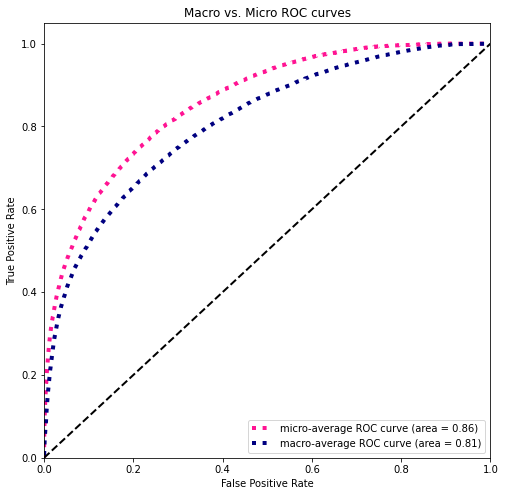

In [ ]:
evaluate_model(trainer, ds_enc_split["test"], 0.2)